# LinearSVC model

## Data preprocessing

In [ ]:
!pip install gensim

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import pandas as pd
import numpy as np
import gensim.models
from nltk.corpus import ConllCorpusReader
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
# Set up paths
train_file_path = r'/CONLL2003/'
new_test_file_path = r'NER-test.tsv'
word_embedding_model_path = r"GoogleNews-vectors-negative300.bin.gz"

In [ ]:
# Load word embedding model
print("--- Loading Word Embedding Model ---")
word_embedding_model = gensim.models.KeyedVectors.load_word2vec_format(
    word_embedding_model_path, binary=True
)
print("Word embedding model loaded.")

--- Loading Word Embedding Model ---
Word embedding model loaded.


In [ ]:
print("\n--- Loading and Processing Training Data (CONLL2003) ---")
train = ConllCorpusReader(train_file_path, 'train.txt', ['words', 'pos', 'ignore', 'chunk'])

# Word embedding extraction for training data
all_train_tokens_for_embeddings = []
train_embedding_labels = []

for token, pos, ne_label in train.iob_words():
    if token != '' and token != 'DOCSTART':
        all_train_tokens_for_embeddings.append(token)
        train_embedding_labels.append(ne_label)

num_tokens_train = len(all_train_tokens_for_embeddings)
input_vectors_np = np.zeros((num_tokens_train, 300))

for i, token in enumerate(all_train_tokens_for_embeddings):
    if token in word_embedding_model:
        input_vectors_np[i] = word_embedding_model[token]
print(f"Training data word embeddings processed. Shape: {input_vectors_np.shape}")

# Word embedding extraction for testing data
print("\n--- Loading and Processing New Test Data ---")
try:
    test_df = pd.read_csv(new_test_file_path, sep='\t')
    print("New test data loaded successfully into DataFrame.")

    
    all_test_tokens_for_embeddings = []
    test_embedding_labels = []

    for _, row in test_df.iterrows():
        token = row.token
        ne_label = row.BIO_NER_tag
        if token != '' and token != 'DOCSTART':
            all_test_tokens_for_embeddings.append(token)
            test_embedding_labels.append(ne_label)

    test_num_tokens = len(all_test_tokens_for_embeddings)
    test_input_vectors_np = np.zeros((test_num_tokens, 300))

    for i, token in enumerate(all_test_tokens_for_embeddings):
        if token in word_embedding_model:
            test_input_vectors_np[i] = word_embedding_model[token]
    print(f"Test data word embeddings processed. Shape: {test_input_vectors_np.shape}")
except Exception as e:
    print(f"An error occurred during test data loading: {e}")
    exit()


# Feature extraction function
print("\n--- Generating Enriched Feature Dictionaries for DictVectorizer ---")
def extract_features(sentence_data, index, is_test_data=False):
    token, pos, ne_label = sentence_data[index]

    features = {
        'token': token,
        'token_lower': token.lower(),
        'is_capitalized': token[0].isupper() if token else False,
        'is_all_caps': token.isupper() if token else False,
        'is_digit': token.isdigit() if token else False,
        'is_alpha': token.isalpha() if token else False,
        'has_hyphen': '-' in token if token else False,
        'prefix_1': token[0] if token else '',
        'prefix_2': token[:2] if token else '',
        'prefix_3': token[:3] if token else '',
        'suffix_1': token[-1] if token else '',
        'suffix_2': token[-2:] if token else '',
        'suffix_3': token[-3:] if token else '',
    }

    if not is_test_data:
        features['pos'] = pos

    if index > 0:
        prev_token, prev_pos, _ = sentence_data[index - 1]
        features['token-1'] = prev_token
        features['token-1_lower'] = prev_token.lower()
        if not is_test_data: features['pos-1'] = prev_pos
    else:
        features['token-1'] = 'START'
        features['token-1_lower'] = 'start'
        if not is_test_data: features['pos-1'] = 'START'

    if index < len(sentence_data) - 1:
        next_token, next_pos, _ = sentence_data[index + 1]
        features['token+1'] = next_token
        features['token+1_lower'] = next_token.lower()
        if not is_test_data: features['pos+1'] = next_pos
    else:
        features['token+1'] = 'END'
        features['token+1_lower'] = 'end'
        if not is_test_data: features['pos+1'] = 'END'

    return features


train_feature_dicts = []
train_labels = []

for sent_idx, sent in enumerate(train.iob_sents()):
    for i, (token, pos, ne_label) in enumerate(sent):
        if token == 'DOCSTART':
            continue
        train_feature_dicts.append(extract_features(sent, i, is_test_data=False))
        train_labels.append(ne_label)
print(f"Generated {len(train_feature_dicts)} enriched feature dictionaries for training data.")


test_feature_dicts = []
test_labels = []

# Group by sentence
grouped_test_df = test_df.groupby('sentence_id')

for sent_id, sentence_df in grouped_test_df:
    sentence_tokens_test = []
    for _, row in sentence_df.iterrows():
        sentence_tokens_test.append((row['token'], None, row['BIO_NER_tag']))

    for i, (token, _, ne_label) in enumerate(sentence_tokens_test):
        test_feature_dicts.append(extract_features(sentence_tokens_test, i, is_test_data=True))
        test_labels.append(ne_label)
print(f"Generated {len(test_feature_dicts)} enriched feature dictionaries for test data.")

# Normalize labels
assert len(train_feature_dicts) == input_vectors_np.shape[0], "Mismatch between train features and embedding count!"
assert len(test_feature_dicts) == test_input_vectors_np.shape[0], "Mismatch between test features and embedding count!"

test_labels_replaced = [
    label.replace('B-LOCATION', 'B-LOC')
         .replace('I-LOCATION', 'I-LOC')
         .replace('B-PERSON', 'B-PER')
         .replace('I-PERSON', 'I-PER')
         .replace('B-WORK_OF_ART', 'B-MISC')
         .replace('I-WORK_OF_ART', 'I-MISC')
    for label in test_labels
]
test_labels = np.array(test_labels_replaced, dtype=object)

print("\n--- Vectorizing Features with DictVectorizer and Combining with Embeddings ---")
all_features = train_feature_dicts + test_feature_dicts

vec = DictVectorizer(sparse=True)
the_array_sparse = vec.fit_transform(all_features)
print(f"Combined sparse feature array shape from DictVectorizer: {the_array_sparse.shape}")

# Split sparse array
X_train_sparse = the_array_sparse[:len(train_feature_dicts)]
X_test_sparse = the_array_sparse[len(train_feature_dicts):]

# Combine sparse features with dense word embeddings using hstack
X_train_final = hstack((X_train_sparse, input_vectors_np))
X_test_final = hstack((X_test_sparse, test_input_vectors_np))

print(f"Final X_train shape (sparse + embeddings): {X_train_final.shape}")
print(f"Final X_test shape (sparse + embeddings): {X_test_final.shape}")

# Prepare labels for the model
y_train = np.array(train_labels, dtype=object)
y_test = np.array(test_labels, dtype=object)

print(f"y_train length: {len(y_train)}")
print(f"y_test length: {len(y_test)}")


--- Loading and Processing Training Data (CONLL2003) ---
Training data word embeddings processed. Shape: (203621, 300)

--- Loading and Processing New Test Data ---
New test data loaded successfully into DataFrame.
Test data word embeddings processed. Shape: (216, 300)

--- Generating Enriched Feature Dictionaries for DictVectorizer ---
Generated 203621 enriched feature dictionaries for training data.
Generated 216 enriched feature dictionaries for test data.

--- Vectorizing Features with DictVectorizer and Combining with Embeddings ---
Combined sparse feature array shape from DictVectorizer: (203837, 144557)
Final X_train shape (sparse + embeddings): (203621, 144857)
Final X_test shape (sparse + embeddings): (216, 144857)
y_train length: 203621
y_test length: 216


## Data analysis


Total number of tokens (excluding DOCSTART): 203621
Total number of sentences (excluding DOCSTART sentences): 14041
Number of unique tokens (vocabulary size): 23623
Number of tokens with missing POS tags (None): 0

NER Label Distribution:
  O: 169578 (83.28%)
  B-LOC: 7140 (3.51%)
  B-PER: 6600 (3.24%)
  B-ORG: 6321 (3.10%)
  I-PER: 4528 (2.22%)
  I-ORG: 3704 (1.82%)
  B-MISC: 3438 (1.69%)
  I-LOC: 1157 (0.57%)
  I-MISC: 1155 (0.57%)


<ipython-input-9-d780dfd18388>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ner_label_counts.keys()), y=list(ner_label_counts.values()), palette="viridis")


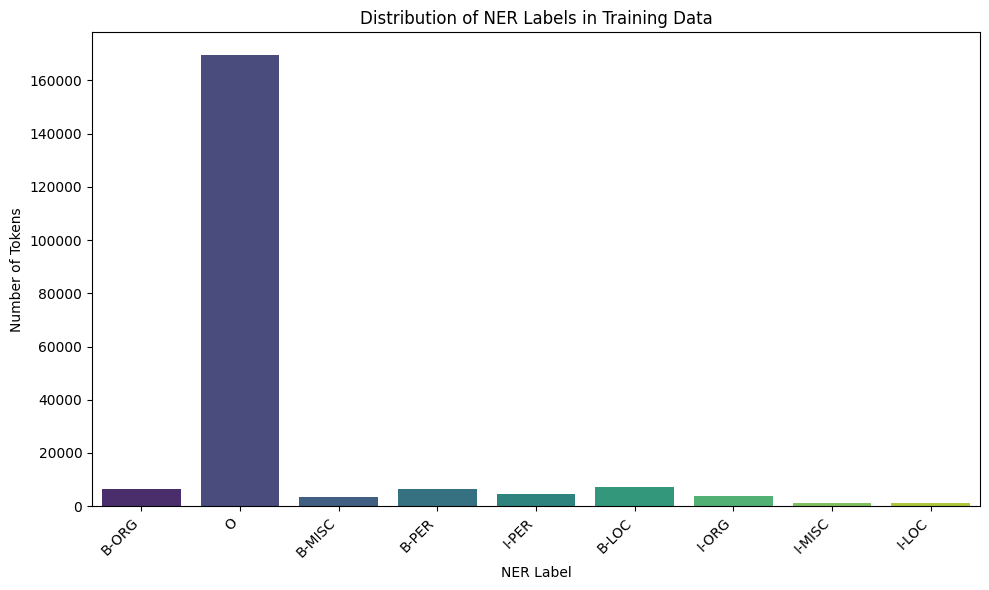


Sentence Length Statistics:
  Min Length: 1
  Max Length: 113
  Mean Length: 14.50
  Median Length: 10.0
  Standard Deviation: 11.60


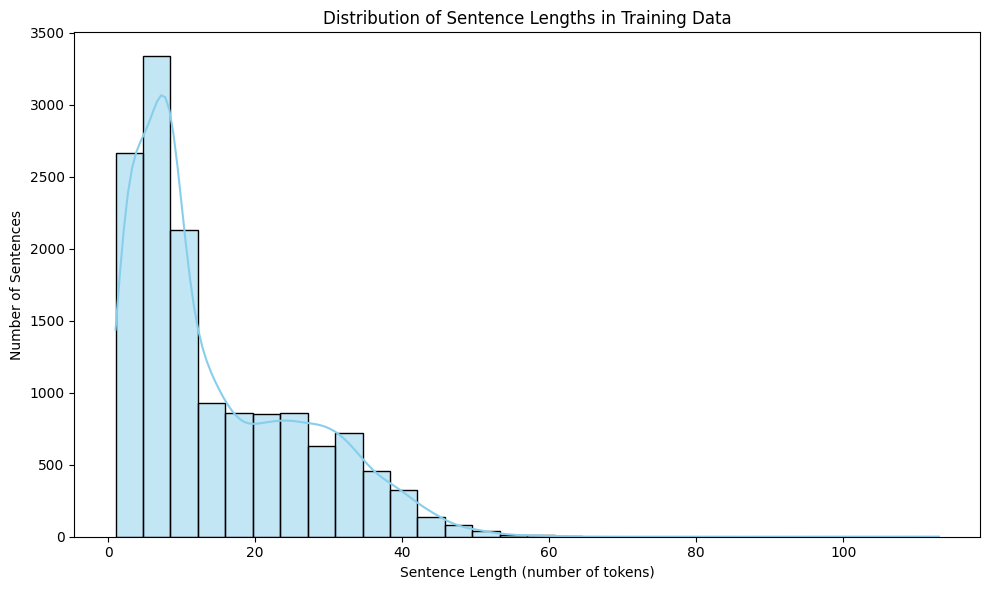


Top 10 POS Tag Distribution:
  NNP: 34392 (16.89%)
  NN: 23899 (11.74%)
  CD: 19704 (9.68%)
  IN: 19064 (9.36%)
  DT: 13453 (6.61%)
  JJ: 11831 (5.81%)
  NNS: 9903 (4.86%)
  VBD: 8293 (4.07%)
  .: 7389 (3.63%)
  ,: 7291 (3.58%)


<ipython-input-9-d780dfd18388>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[tag for tag, _ in top_10_pos], y=[count for _, count in top_10_pos], palette="plasma")


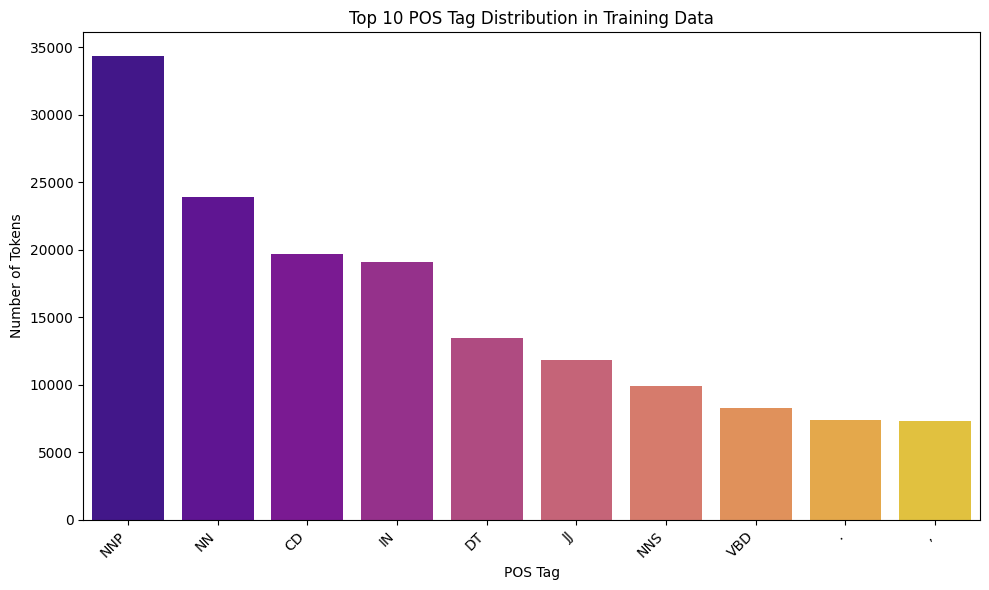


--- Data Analysis Complete ---


In [ ]:
# Data analysis for train dataset
all_tokens = []
all_ner_labels = []
all_pos_tags = []
sentence_lengths = []

for token, pos, ne_label in train.iob_words():
    if token == 'DOCSTART':
        continue

    all_tokens.append(token)
    all_ner_labels.append(ne_label)
    all_pos_tags.append(pos)

for sentence in train.iob_sents():
    filtered_sentence = [token for token, _, _ in sentence if token != 'DOCSTART']
    if filtered_sentence:
        sentence_lengths.append(len(filtered_sentence))

num_tokens = len(all_tokens)
num_sentences = len(sentence_lengths)
unique_tokens = len(set(all_tokens))

print(f"\nTotal number of tokens (excluding DOCSTART): {num_tokens}")
print(f"Total number of sentences (excluding DOCSTART sentences): {num_sentences}")
print(f"Number of unique tokens (vocabulary size): {unique_tokens}")

pos_nans = sum(1 for tag in all_pos_tags if tag is None)
print(f"Number of tokens with missing POS tags (None): {pos_nans}")

ner_label_counts = Counter(all_ner_labels)
print("\nNER Label Distribution:")
for label, count in ner_label_counts.most_common():
    percentage = (count / num_tokens) * 100
    print(f"  {label}: {count} ({percentage:.2f}%)")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(ner_label_counts.keys()), y=list(ner_label_counts.values()), palette="viridis")
plt.title('Distribution of NER Labels in Training Data')
plt.xlabel('NER Label')
plt.ylabel('Number of Tokens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nSentence Length Statistics:")
print(f"  Min Length: {np.min(sentence_lengths)}")
print(f"  Max Length: {np.max(sentence_lengths)}")
print(f"  Mean Length: {np.mean(sentence_lengths):.2f}")
print(f"  Median Length: {np.median(sentence_lengths)}")
print(f"  Standard Deviation: {np.std(sentence_lengths):.2f}")

plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Number of Sentences')
plt.tight_layout()
plt.show()

pos_tag_counts = Counter(all_pos_tags)
print("\nTop 10 POS Tag Distribution:")
for tag, count in pos_tag_counts.most_common(10):
    percentage = (count / num_tokens) * 100
    print(f"  {tag}: {count} ({percentage:.2f}%)")

top_10_pos = pos_tag_counts.most_common(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=[tag for tag, _ in top_10_pos], y=[count for _, count in top_10_pos], palette="plasma")
plt.title('Top 10 POS Tag Distribution in Training Data')
plt.xlabel('POS Tag')
plt.ylabel('Number of Tokens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- Data Analysis Complete ---")


--- Starting Data Analysis for Test Dataset ---
Successfully loaded test data from: /content/drive/MyDrive/vu_tm/NER-test.tsv

--- Test Data Statistics ---
Total number of tokens: 216
Total number of sentences: 15
Number of unique tokens (vocabulary size): 155
Number of tokens with missing POS tags (None) in Test Data: 216

NER Label Distribution (Test Data):
  O: 159 (73.61%)
  I-PERSON: 13 (6.02%)
  B-PERSON: 12 (5.56%)
  B-ORG: 8 (3.70%)
  I-WORK_OF_ART: 8 (3.70%)
  B-WORK_OF_ART: 6 (2.78%)
  I-ORG: 5 (2.31%)
  B-LOCATION: 3 (1.39%)
  I-LOCATION: 2 (0.93%)


<ipython-input-11-f2b52d61c7c8>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ner_label_counts_test.keys()), y=list(ner_label_counts_test.values()), palette="viridis")


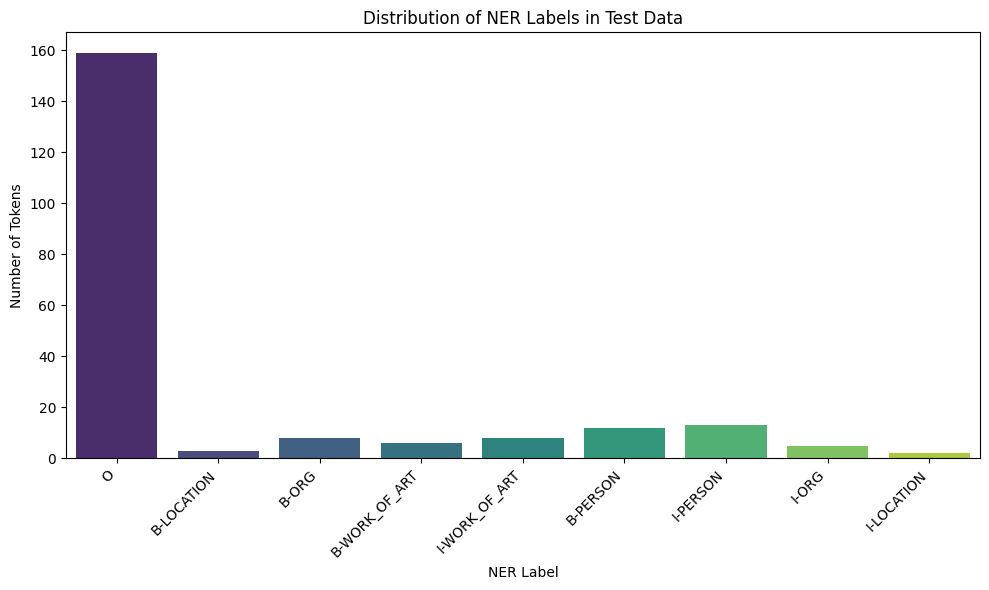


Sentence Length Statistics (Test Data):
  Min Length: 9
  Max Length: 20
  Mean Length: 14.40
  Median Length: 15.0
  Standard Deviation: 3.22


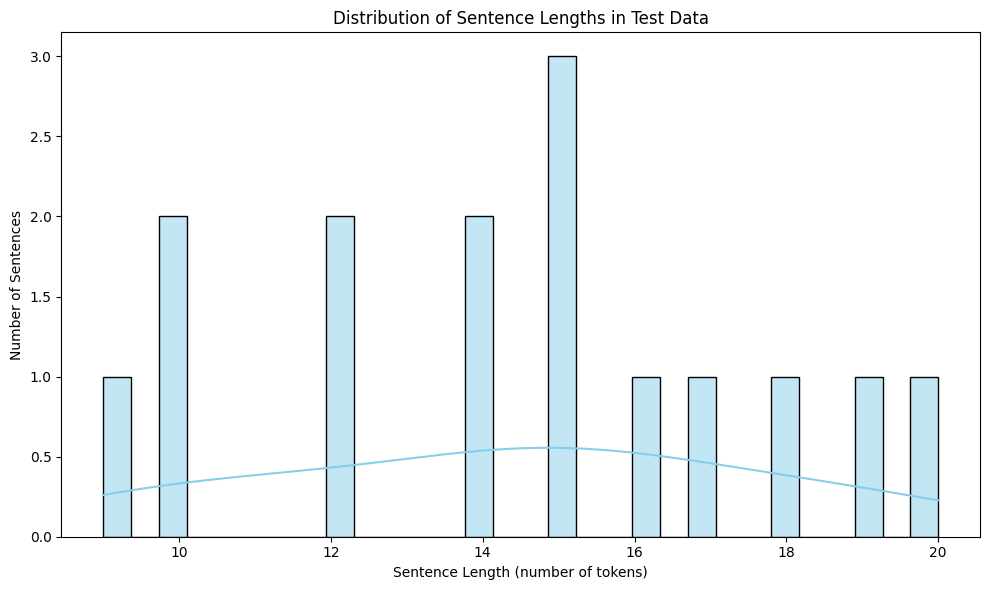


POS Tag Distribution (Test Data) - Expected to be mostly 'None':
  None: 216 (100.00%)


<ipython-input-11-f2b52d61c7c8>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(tag) for tag, _ in top_10_pos_test], y=[count for _, count in top_10_pos_test], palette="plasma")


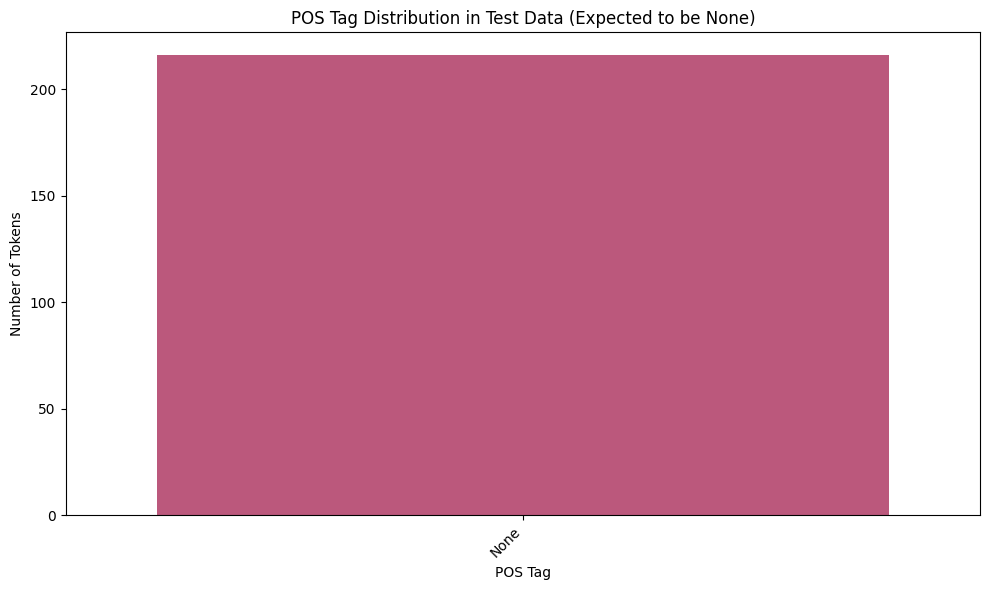


--- Data Analysis Complete ---


In [ ]:
# Data analysis for test dataset
print("\n--- Starting Data Analysis for Test Dataset ---")

all_tokens_test = []
all_ner_labels_test = []
all_pos_tags_test = []
sentence_lengths_test = []

grouped_test_df = test_df.groupby('sentence_id')

for sent_id, sentence_df in grouped_test_df:
    current_sentence_tokens = []
    for _, row in sentence_df.iterrows():
        token = row['token']
        ne_label = row['BIO_NER_tag']

        all_tokens_test.append(token)
        all_ner_labels_test.append(ne_label)
        all_pos_tags_test.append(None)

        current_sentence_tokens.append(token)

    if current_sentence_tokens:
        sentence_lengths_test.append(len(current_sentence_tokens))

num_tokens_test = len(all_tokens_test)
num_sentences_test = len(sentence_lengths_test)
unique_tokens_test = len(set(all_tokens_test))

print(f"\n--- Test Data Statistics ---")
print(f"Total number of tokens: {num_tokens_test}")
print(f"Total number of sentences: {num_sentences_test}")
print(f"Number of unique tokens (vocabulary size): {unique_tokens_test}")

pos_nans_test = sum(1 for tag in all_pos_tags_test if tag is None)
print(f"Number of tokens with missing POS tags (None) in Test Data: {pos_nans_test}")

ner_label_counts_test = Counter(all_ner_labels_test)
print("\nNER Label Distribution (Test Data):")
for label, count in ner_label_counts_test.most_common():
    percentage = (count / num_tokens_test) * 100
    print(f"  {label}: {count} ({percentage:.2f}%)")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(ner_label_counts_test.keys()), y=list(ner_label_counts_test.values()), palette="viridis")
plt.title('Distribution of NER Labels in Test Data')
plt.xlabel('NER Label')
plt.ylabel('Number of Tokens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nSentence Length Statistics (Test Data):")
print(f"  Min Length: {np.min(sentence_lengths_test)}")
print(f"  Max Length: {np.max(sentence_lengths_test)}")
print(f"  Mean Length: {np.mean(sentence_lengths_test):.2f}")
print(f"  Median Length: {np.median(sentence_lengths_test)}")
print(f"  Standard Deviation: {np.std(sentence_lengths_test):.2f}")

plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths_test, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentence Lengths in Test Data')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Number of Sentences')
plt.tight_layout()
plt.show()

pos_tag_counts_test = Counter(all_pos_tags_test)
print("\nPOS Tag Distribution (Test Data) - Expected to be mostly 'None':")
for tag, count in pos_tag_counts_test.most_common(10):
    percentage = (count / num_tokens_test) * 100
    print(f"  {tag}: {count} ({percentage:.2f}%)")

top_10_pos_test = pos_tag_counts_test.most_common(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=[str(tag) for tag, _ in top_10_pos_test], y=[count for _, count in top_10_pos_test], palette="plasma")
plt.title('POS Tag Distribution in Test Data (Expected to be None)')
plt.xlabel('POS Tag')
plt.ylabel('Number of Tokens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- Data Analysis Complete ---")

## LinearSVC training and eval

In [ ]:
# Training LinearSVC
print("\n--- Training LinearSVC Model ---")
lin_clf = LinearSVC(dual=False, class_weight='balanced', C=1.0, max_iter=1000)
lin_clf.fit(X_train_final, y_train)
print("Model training complete.")

# Eval
print("\n--- Evaluating Model Performance ---")
y_pred = lin_clf.predict(X_test_final)

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred, zero_division=0))


--- Training LinearSVC Model ---
Model training complete.

--- Evaluating Model Performance ---

Classification Report on Test Data:
              precision    recall  f1-score   support

       B-LOC       0.38      1.00      0.55         3
      B-MISC       0.00      0.00      0.00         6
       B-ORG       1.00      0.62      0.77         8
       B-PER       0.47      0.67      0.55        12
       I-LOC       0.50      0.50      0.50         2
      I-MISC       0.50      0.12      0.20         8
       I-ORG       0.75      0.60      0.67         5
       I-PER       1.00      0.15      0.27        13
           O       0.92      1.00      0.96       159

    accuracy                           0.84       216
   macro avg       0.61      0.52      0.50       216
weighted avg       0.85      0.84      0.82       216



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# BERT model

## Data preprocessing

In [ ]:
!pip install -U transformers seqeval

In [ ]:
# Imports
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import ConllCorpusReader
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from seqeval.metrics import classification_report as seq_classification_report, f1_score as seq_f1_score, accuracy_score
import os

In [ ]:
# Data preprocessing for bert

# Training dataset
def normalize_ner_tag(tag):
    replacements = {
        'B-LOCATION': 'B-LOC',
        'I-LOCATION': 'I-LOC',
        'B-PERSON': 'B-PER',
        'I-PERSON': 'I-PER',
        'B-WORK_OF_ART': 'B-MISC',
        'I-WORK_OF_ART': 'I-MISC',
    }
    return replacements.get(tag, tag)

print("--- Preparing Data for BERT ---")

train_data_bert_format = []

for sent_tokens_pos_labels in ConllCorpusReader(train_file_path, 'train.txt', ['words', 'pos', 'ignore', 'chunk']).iob_sents():
    current_sentence = []
    for token, pos, ne_label in sent_tokens_pos_labels:
        if token == 'DOCSTART':
            continue
        current_sentence.append((token, ne_label))
    if current_sentence:
        train_data_bert_format.append(current_sentence)

print(f"Loaded {len(train_data_bert_format)} training sentences.")
# print("Example train sentence:", train_data_bert_format[0])

# Testing dataset
test_data_bert_format = []
try:
    test_df = pd.read_csv(new_test_file_path, sep='\t')
except FileNotFoundError:
    print(f"Error: The new test file '{new_test_file_path}' was not found. Please check the path.")
    exit()

grouped_test_df = test_df.groupby('sentence_id')
for _, sentence_df in grouped_test_df:
    current_sentence = []
    for _, row in sentence_df.iterrows():
        current_sentence.append((row['token'], normalize_ner_tag(row['BIO_NER_tag'])))
    if current_sentence:
        test_data_bert_format.append(current_sentence)

print(f"Loaded {len(test_data_bert_format)} test sentences.")
# print("Example test sentence:", test_data_bert_format[0])

unique_labels = sorted(list(set(label for sentence in train_data_bert_format + test_data_bert_format for _, label in sentence)))

label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Tokenization for BERT
label_to_id["X"] = -100
num_labels = len(unique_labels)

print(f"Unique labels found: {unique_labels}")
print(f"Label to ID mapping: {label_to_id}")

# Helper class
class NERDataset(Dataset):
    def __init__(self, data, tokenizer, label_to_id, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.label_to_id = label_to_id
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = zip(*self.data[idx])

        tokenized_inputs = self.tokenizer(
            list(tokens),
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            is_split_into_words=True,
            return_offsets_mapping=True
        )

        word_ids = tokenized_inputs.word_ids(batch_index=0)
        aligned_labels = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                aligned_labels.append(self.label_to_id[labels[word_idx]])
            else:
                aligned_labels.append(-100)
            previous_word_idx = word_idx

        tokenized_inputs["labels"] = aligned_labels

        return {
            "input_ids": torch.tensor(tokenized_inputs["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized_inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(tokenized_inputs["labels"], dtype=torch.long),
        }

# Create dataset instances
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

max_length = 128
train_dataset = NERDataset(train_data_bert_format, tokenizer, label_to_id, max_length)
test_dataset = NERDataset(test_data_bert_format, tokenizer, label_to_id, max_length)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

--- Preparing Data for BERT ---
Loaded 14041 training sentences.
Loaded 15 test sentences.
Unique labels found: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
Label to ID mapping: {'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8, 'X': -100}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train dataset size: 14041
Test dataset size: 15


## BERT training

In [ ]:
# Set up computational metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_predictions = [[id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                        for prediction, label in zip(predictions, labels)]

    results = seq_classification_report(true_labels, true_predictions, output_dict=True, zero_division=0)
    res_accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "precision": results["micro avg"]["precision"],
        "recall": results["micro avg"]["recall"],
        "f1": results["micro avg"]["f1-score"],
        "overall_accuracy": res_accuracy,
    }

# Set up parameters for BERT
training_args = TrainingArguments(
    output_dir="./bert_ner_results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./bert_ner_logs",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    learning_rate=2e-5
)

# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-15-dc960c1275a8>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the Model
print("\n--- Starting BERT Model Training ---")
trainer.train()
print("BERT Model Training complete.")


--- Starting BERT Model Training ---


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Overall Accuracy
1,0.063000,0.592243,0.629630,0.586207,0.607143,0.879630
2,0.030500,0.438751,0.586207,0.586207,0.586207,0.888889
3,0.022000,0.635233,0.655172,0.655172,0.655172,0.884259
4,0.008000,0.549303,0.645161,0.689655,0.666667,0.902778
5,0.006300,0.653919,0.689655,0.689655,0.689655,0.902778


BERT Model Training complete.


Metrics Data:
   Epoch  Training Loss  Validation Loss  Precision    Recall  F1-score  \
0      1         0.0630         0.592243   0.629630  0.586207  0.607143   
1      2         0.0305         0.438751   0.586207  0.586207  0.586207   
2      3         0.0220         0.635233   0.655172  0.655172  0.655172   
3      4         0.0080         0.549303   0.645161  0.689655  0.666667   
4      5         0.0063         0.653919   0.689655  0.689655  0.689655   

   Overall Accuracy  
0          0.879630  
1          0.888889  
2          0.884259  
3          0.902778  
4          0.902778  


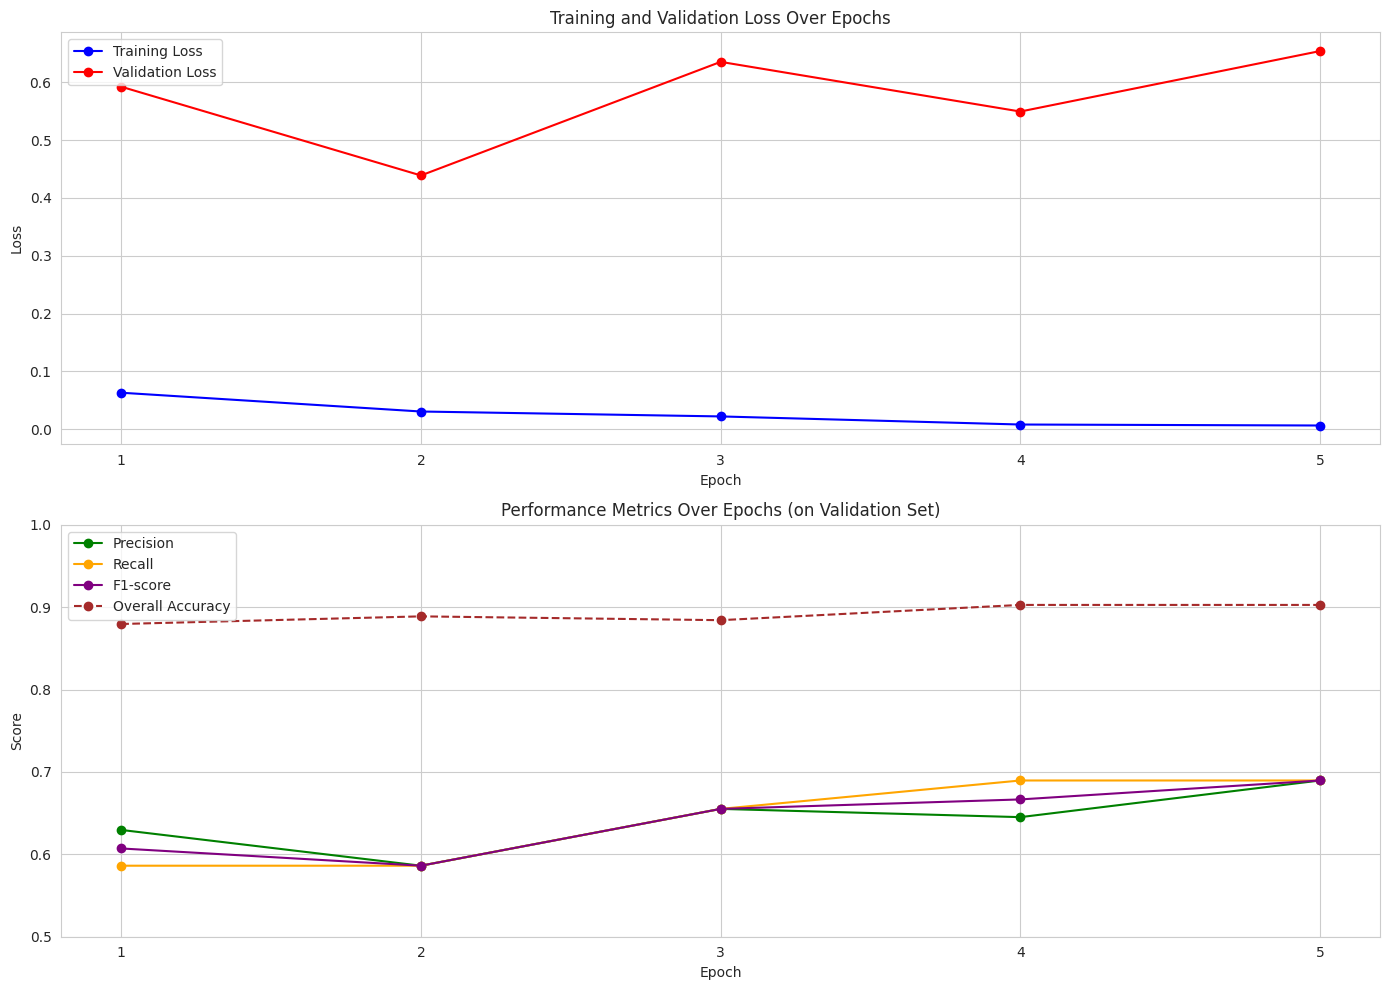


Graphs showing BERT model training progress have been generated.


In [ ]:
# Training analysis

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

epochs = [1, 2, 3, 4, 5]
training_loss = [0.063000, 0.030500, 0.022000, 0.008000, 0.006300]
validation_loss = [0.592243, 0.438751, 0.635233, 0.549303, 0.653919]
precision = [0.629630, 0.586207, 0.655172, 0.645161, 0.689655]
recall = [0.586207, 0.586207, 0.655172, 0.689655, 0.689655]
f1 = [0.607143, 0.586207, 0.655172, 0.666667, 0.689655]
overall_accuracy = [0.879630, 0.888889, 0.884259, 0.902778, 0.902778]

df_metrics = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': training_loss,
    'Validation Loss': validation_loss,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Overall Accuracy': overall_accuracy
})

print("Metrics Data:")
print(df_metrics)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(df_metrics['Epoch'], df_metrics['Training Loss'], marker='o', label='Training Loss', color='blue')
plt.plot(df_metrics['Epoch'], df_metrics['Validation Loss'], marker='o', label='Validation Loss', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_metrics['Epoch'], df_metrics['Precision'], marker='o', label='Precision', color='green')
plt.plot(df_metrics['Epoch'], df_metrics['Recall'], marker='o', label='Recall', color='orange')
plt.plot(df_metrics['Epoch'], df_metrics['F1-score'], marker='o', label='F1-score', color='purple')
plt.plot(df_metrics['Epoch'], df_metrics['Overall Accuracy'], marker='o', label='Overall Accuracy', color='brown', linestyle='--')
plt.title('Performance Metrics Over Epochs (on Validation Set)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

print("\nGraphs showing BERT model training progress have been generated.")

## BERT eval

In [ ]:
# Model testing and evaluation
print("\n--- Evaluating BERT Model on Test Set ---")
eval_results = trainer.evaluate()
print(eval_results)

predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=2)

true_labels_final = [[id_to_label[l] for l in label if l != -100] for label in labels]
true_predictions_final = [[id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                          for prediction, label in zip(predictions, labels)]

print("\nDetailed BERT Classification Report on Test Data (Final Model):")
print(seq_classification_report(true_labels_final, true_predictions_final, zero_division=0))


--- Evaluating BERT Model on Test Set ---


{'eval_loss': 0.6539192795753479, 'eval_precision': 0.6896551724137931, 'eval_recall': 0.6896551724137931, 'eval_f1': 0.6896551724137931, 'eval_overall_accuracy': 0.9027777777777778, 'eval_runtime': 0.1518, 'eval_samples_per_second': 98.789, 'eval_steps_per_second': 6.586, 'epoch': 5.0}

Detailed BERT Classification Report on Test Data (Final Model):
              precision    recall  f1-score   support

         LOC       0.75      1.00      0.86         3
        MISC       0.50      0.50      0.50         6
         ORG       0.67      0.75      0.71         8
         PER       0.80      0.67      0.73        12

   micro avg       0.69      0.69      0.69        29
   macro avg       0.68      0.73      0.70        29
weighted avg       0.70      0.69      0.69        29

